<a href="https://colab.research.google.com/github/sandmman/coms-4995-finalproject/blob/main/Final-Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [78]:
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, DepthwiseConv2D, ReLU, Dense, AveragePooling2D, Softmax, Reshape, Activation
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteL6F2HC/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteL6F2HC/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


tf.Tensor(36, shape=(), dtype=int64)
tf.Tensor(118, shape=(), dtype=int64)
tf.Tensor(46, shape=(), dtype=int64)
tf.Tensor(103, shape=(), dtype=int64)
tf.Tensor(113, shape=(), dtype=int64)
tf.Tensor(116, shape=(), dtype=int64)
tf.Tensor(70, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor(95, shape=(), dtype=int64)


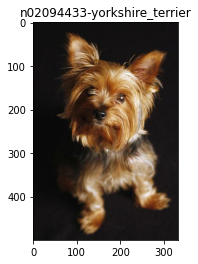

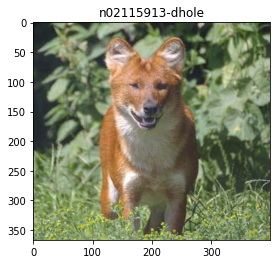

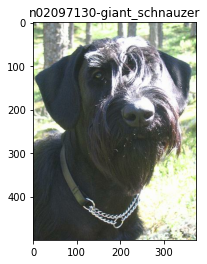

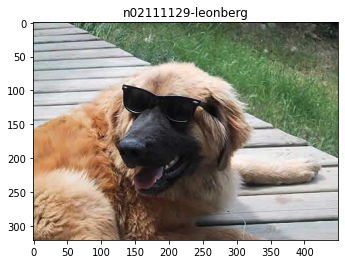

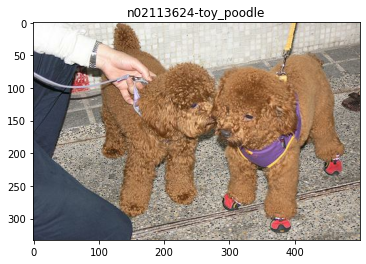

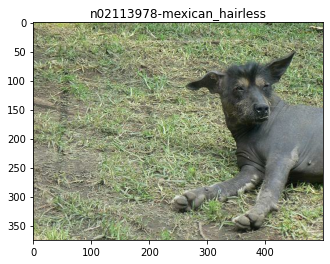

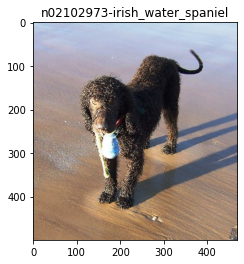

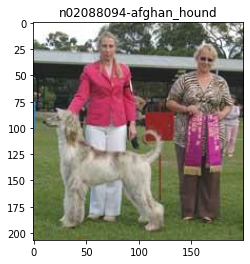

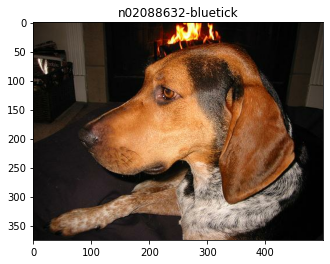

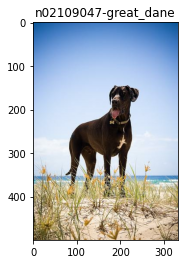

In [64]:
get_name = metadata.features['label'].int2str
for dog in train_ds.take(10):
    plt.figure()
    plt.imshow(dog[0])
    plt.title(get_name(dog[1]))

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_LABELS = 120

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [6]:
def preprocess(rho=1):
    """returns the sample preprocess method

    Keyword arguments:
      rho -- the resolution multiplier as defined by the MobileNet paper. This
      is responsible for scaling the input image and reducing the overal cost of
      the network
    """
    scaled_img_size = IMG_SIZE * rho
    
    def sub_preprocess(image, label):
      image = tf.image.convert_image_dtype(image, dtype=tf.float32)
      image = tf.image.resize(image, (scaled_img_size, scaled_img_size), method='nearest')

      # Onehot encoding labels
      label = tf.one_hot(label, NUM_LABELS)
      return image, label
    
    return sub_preprocess

def prepare(ds, shuffle=False, augment=False, rho=1):
  ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(BATCH_SIZE)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
prepared_train_ds = prepare(train_ds, shuffle=True, augment=True)
prepared_val_ds = prepare(val_ds)
prepared_test_ds = prepare(test_ds)

In [70]:
class DepthwiseSeparableConv2D(tf.keras.layers.Layer):
    """DepthwiseSeparableConv2D encapsulates a Keras Layer implementation of the 
    Depthwise Separable Convolution defined in the MobileNet paper
    
    https://arxiv.org/pdf/1704.04861.pdf
    """

    def __init__(self, filters, alpha=1, strides=1, idx=0):
      """initializes an instance of DepthwiseSeparableConv2D

      Keyword arguments:
        filters -- the number of pointwise convolutional filters to use
        alpha -- the layer's width multiplier (0-1.0) 
        strides -- the number of strides used for the first depthwise convolution
        idx -- the layer index number used for logging
      """
      super(DepthwiseSeparableConv2D, self).__init__()

      self.pointwise_conv_filters = int(filters * alpha)

      self.layer1 = DepthwiseConv2D((3, 3), 
                            depth_multiplier=1, 
                            padding='same', 
                            strides=strides, 
                            name="__depthwiseconv2D_{}".format(idx))
      self.layer2 = BatchNormalization(name="__batchnormalization1_{}".format(idx))
      self.layer3 = ReLU(name="__relu1__{}".format(idx))
      self.layer4 = Conv2D(self.pointwise_conv_filters, 
                        (1, 1), 
                        padding='same', 
                        name="__conv2D__{}".format(idx))
      self.layer5 = BatchNormalization(name="__batchnormalization2_{}".format(idx))
      self.layer6 = ReLU(name="__relu2__{}".format(idx))

    def call(self, inputs):
      """begins execution of the layer

      Keyword arguments:
        inputs -- the input to the model
      """
      output = self.layer1(inputs)
      output = self.layer2(output)
      output = self.layer3(output)
      output = self.layer4(output)
      output = self.layer5(output)
      output = self.layer6(output)
      return output

In [67]:
class MobileNet(tf.keras.Model):
  """MobileNet encapsulates a Keras Model implementation of the MobileNet 
  Architecture as defined in https://arxiv.org/pdf/1704.04861.pdf
  """

  def __init__(self, num_classes=NUM_LABELS, alpha=1):
    """initilizes an instance of MobileNet

    Keyword arguments:
      num_classes -- the number of output classes in the softmax layer
      alpha -- the network's width multiplier (0-1.0)
    """
    super(MobileNet, self).__init__()

    self.num_classes = num_classes
    self.alpha = alpha
    self.model_layers = self._get_model_layers()



  def call(self, inputs, training=True):
    """begins execution of the model

    Keyword arguments:
      inputs -- the input to the model
      training -- denotes if the model is under training
    """
    output = inputs
    for layer in self.model_layers:
      output = layer(output)
    return output
  
  def _get_model_layers(self):
    """
    Keyword arguments:
      model -- the real part (default 0.0)
      filters -- the number of filters to apply on the pointwise layer
    """

    alpha = self.alpha
    num_classes = self.num_classes

    # We then construct out model using a sequential set of Keras layers
    layers = []

    # Model begins with a simple convolutional layer
    layers.append(Conv2D(32, (3, 3), strides=2, padding='SAME', name="__conv2d__0"))

    # Followed by increasing depthwise seperable convolutions
    layers.append(DepthwiseSeparableConv2D(64, alpha=alpha, strides=1, idx=1))
    layers.append(DepthwiseSeparableConv2D(128, alpha=alpha, strides=2, idx=2))
    layers.append(DepthwiseSeparableConv2D(128, alpha=alpha, strides=1, idx=3))
    layers.append(DepthwiseSeparableConv2D(256, alpha=alpha, strides=2, idx=4))
    layers.append(DepthwiseSeparableConv2D(256, alpha=alpha, strides=1, idx=5))
    layers.append(DepthwiseSeparableConv2D(512, alpha=alpha, strides=2, idx=6))

    # 5x depthwise separable convolutions at 512 filters
    layers.append(DepthwiseSeparableConv2D(512, alpha=alpha, strides=1, idx=7))
    layers.append(DepthwiseSeparableConv2D(512, alpha=alpha, strides=1, idx=8))
    layers.append(DepthwiseSeparableConv2D(512, alpha=alpha, strides=1, idx=9))
    layers.append(DepthwiseSeparableConv2D(512, alpha=alpha, strides=1, idx=10))
    layers.append(DepthwiseSeparableConv2D(512, alpha=alpha, strides=1, idx=11))

    layers.append(DepthwiseSeparableConv2D(1024, alpha=alpha, strides=2, idx=12))
    layers.append(DepthwiseSeparableConv2D(1024, alpha=alpha, strides=1, idx=13))
    
    # This section represents the top of the model where we pool
    # and return the expected softmax output
    layers.append(AveragePooling2D(pool_size=(7, 7)))
    layers.append(Dense(num_classes, activation='softmax'))
    layers.append(Reshape((num_classes,)))

    return layers

In [58]:
model.summary()

Model: "mobile_net_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   multiple                  3362680   
Total params: 3,362,680
Trainable params: 3,340,856
Non-trainable params: 21,824
_________________________________________________________________


In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend();
plt.savefig('lc.svg')

In [73]:
models = [
          MobileNet(),
          MobileNet(alpha=0.75),
          MobileNet(alpha=0.5),
          MobileNet(alpha=0.25)
        ]

In [80]:
# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

# Although the paper used RMS Prop, we chose to use the Adam optimizer
# because it tends to converge faster than RMS Prop.
optimizer = Adam()


In [83]:
for model in models:

  # Compile the model
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=['accuracy', 'top_k_categorical_accuracy']
                )
  
  history = model.fit(prepared_train_ds,
                    epochs=50,
                    validation_data=prepared_test_ds,
                    callbacks=[tensorboard_callback])

Epoch 1/50
300/300 [==============================] - 60s 184ms/step - loss: 4.9495 - accuracy: 0.0169 - top_k_categorical_accuracy: 0.0753 - val_loss: 5.7726 - val_accuracy: 0.0058 - val_top_k_categorical_accuracy: 0.0333
Epoch 2/50
300/300 [==============================] - 58s 185ms/step - loss: 4.5557 - accuracy: 0.0306 - top_k_categorical_accuracy: 0.1227 - val_loss: 6.1003 - val_accuracy: 0.0100 - val_top_k_categorical_accuracy: 0.0558
Epoch 3/50
300/300 [==============================] - 57s 182ms/step - loss: 4.3636 - accuracy: 0.0416 - top_k_categorical_accuracy: 0.1651 - val_loss: 4.5244 - val_accuracy: 0.0467 - val_top_k_categorical_accuracy: 0.1575
Epoch 4/50
300/300 [==============================] - 57s 181ms/step - loss: 4.2524 - accuracy: 0.0455 - top_k_categorical_accuracy: 0.1996 - val_loss: 4.6030 - val_accuracy: 0.0342 - val_top_k_categorical_accuracy: 0.1342
Epoch 5/50
300/300 [==============================] - 57s 183ms/step - loss: 4.1670 - accuracy: 0.0587 - top

KeyboardInterrupt: ignored

In [ ]:
%tensorboard --logdir logs